In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster, mixture
import validation_lib
import transform_lib
import stats_lib

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# load the necessary datasetes
df_di = data_lib.load_dataset(None, [
    "po-di-se-2-A4", "po-di-se-2-B1", "po-di-se-2-C1", "po-di-se-2-C4",
    "po-di-se-2-D1", "po-di-se-2-D4", "po-di-se-2-A1", "po-di-se-2-B4",

    "po-di-se-1-D4", "po-di-se-1-D1", "po-di-se-1-B4", "po-di-se-1-A4",
    "po-di-se-1-B1", "po-di-se-1-C4", "po-di-se-1-A1", "po-di-se-1-C1",

    "po-di-se-B8", "po-di-se-D8", "po-di-se-A8", "po-di-se-C8",
                                     ], 
                              datafolder="../../Data")


df_negative_control = data_lib.load_dataset([],[
    "po-di-se-1-D1", "po-di-se-1-D4",
    "po-di-se-2-D1", "po-di-se-2-D4",
    "po-di-se-D8",
                                                ], 
                                            datafolder="../../Data")
# Everything is positive contol
df_positive_control = df_di.iloc[:,:6]

# convert to numpy
np_di = df_di.to_numpy(copy=True)[:,:6]
np_negative_control = df_negative_control.to_numpy()

In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, n_jobs=4, min_samples=6, leaf_size=5)
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.ClusterHierarchyDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.95,
                                     eps=0.25,
                                     contamination=0.004,
                                     density_quantile=0.5,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_di, verbose=True)

Time to remove Negatives: 0.008941650390625 seconds.
Time for Clustering: 2.572293996810913 seconds.
Time for Whitening: 0.04245615005493164 seconds.
Time for Cluster Features: 0.7240440845489502 seconds.
Time for Predictions: 0.3692758083343506 seconds.
Time for Cluster Features (2): 2.6226043701171875e-06 seconds.
Time to build Density estimation: 2.4204792976379395 seconds.
Time to compute point probabilies: 9.748759269714355 seconds.


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.000977463022389436, n_outlier: 477

Total error rate: 0.012429064570185607
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.000633     0.055267   0.011744   0.003004   0.001409 0.002517

Precision (TP / (TP + FP)): 0.9717381435884113
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.99965     0.785135   0.996818   0.999265   0.999247 0.999292

Recall / TPR (TP / (TP + FN)): 0.9376637377075955
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.997142     0.613383   0.996696    0.99649   0.999682 0.999721

Specificity / TNR (TN / (TN + FP)): 0.9973574864591317
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999969     0.984694   0.999695   0.999921   0.999923 0.999933

Accuracy ((TP + TN) / (P + N)): 0.9920841678203486
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999737     0.953666   0.999432   0.999585   0.999901 0.999915

F1 (2 * (precision * 

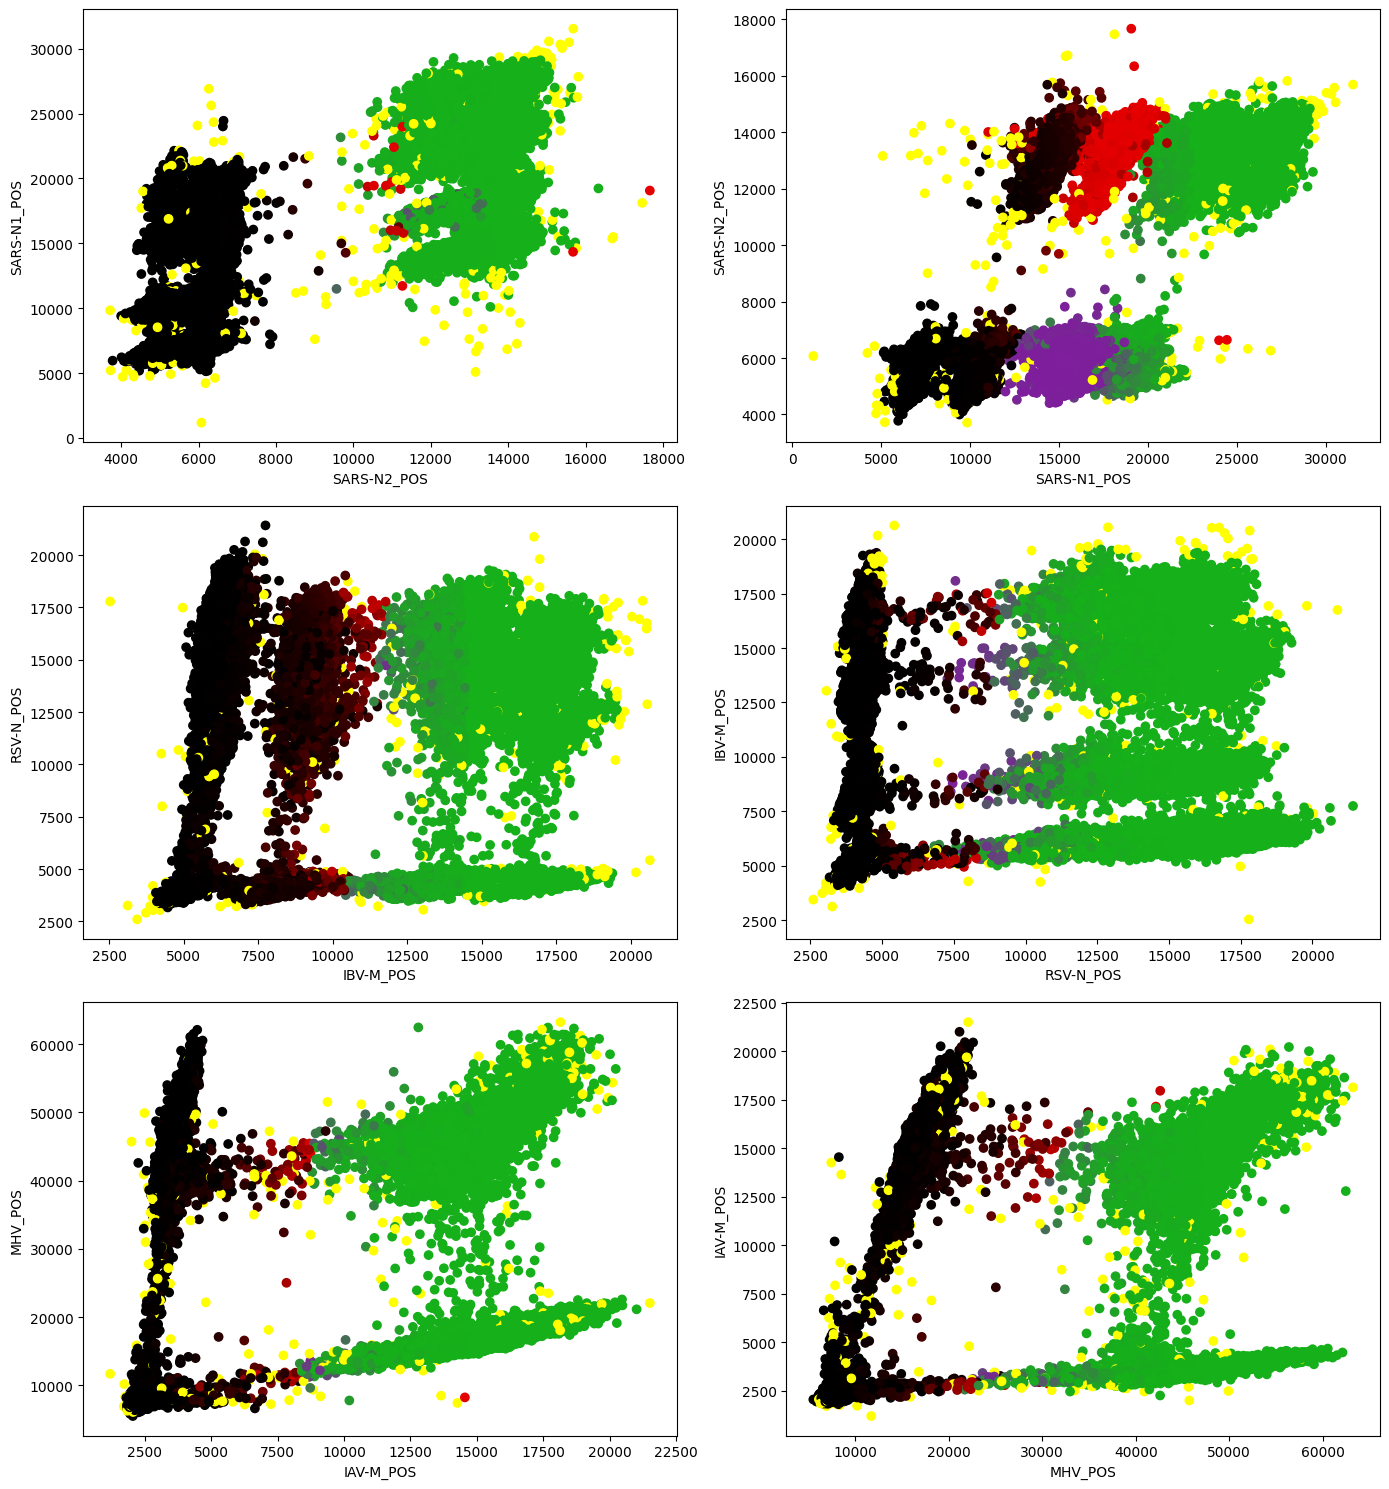

In [5]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

mask = decision.No_neg_mask
validation_lib.validate_labels(df_true_labels=df_di, df_predicted_labels=decision.probabilities_df, verbosity=1, threshold=0.5)

df_result = stats_lib.compute_results(decision.probabilities_df, 0.40, 0.60, df_data_points)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        decision.probabilities_df,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

In [6]:
validation_lib.validate_combinations(df_di, df_decision, verbosity=0)

Total number of outlayer: 477

Label combination ('SARS-N2_POS',):
n outliers: 8, n_true_pos: 7739
Balanced Accuracy: 0.994563826611484

Label combination ('SARS-N1_POS',):
n outliers: 2, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('IBV-M_POS',):
n outliers: 5, n_true_pos: 10092
Balanced Accuracy: 0.9935257447550816

Label combination ('RSV-N_POS',):
n outliers: 6, n_true_pos: 11404
Balanced Accuracy: 0.9975443179947092

Label combination ('IAV-M_POS',):
n outliers: 4, n_true_pos: 5750
Balanced Accuracy: 0.9979954888160312

Label combination ('MHV_POS',):
n outliers: 10, n_true_pos: 9145
Balanced Accuracy: 0.9962005606664632

Label combination ('SARS-N2_POS', 'SARS-N1_POS'):
n outliers: 10, n_true_pos: 4257
Balanced Accuracy: 0.9993979013009502

Label combination ('SARS-N2_POS', 'IBV-M_POS'):
n outliers: 5, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N2_POS', 'RSV-N_POS'):
n outliers: 8, n_true_pos: 1246
Balanced Acc

In [7]:
df_result.to_csv("test_di.csv")